# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [56]:
# Suppress warnings and set environment variables
import os
import warnings
os.environ['COMET_DISABLE_AUTO_LOGGING'] = '1'  # Disable auto-logging warnings
os.environ['COMET_LOGGING_FILE_LEVEL'] = 'ERROR'  # Reduce Comet logging
warnings.filterwarnings('ignore', category=UserWarning)

# Import comet_ml BEFORE torch to enable auto-logging
import comet_ml

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import time

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [ ]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    
    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3, 
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=0)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=0)
    
    return train_loader, val_loader, test_loader
    

In [26]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, 
                                                         transform_train=transform)

Files already downloaded and verified
Files already downloaded and verified


Посмотрим на изображения:

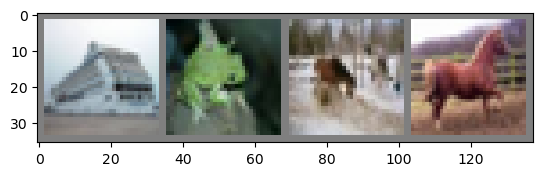

ship frog horse horse


In [27]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [28]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.shortcut = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=1),
            nn.BatchNorm2d(32)
        )
        
        self.pool = nn.AvgPool2d(kernel_size=8)
        self.fc = nn.Linear(32 * 4 * 4, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += self.shortcut(x)
        out = self.relu(out)
        
        out = self.pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out

In [29]:
net = BasicBlockNet()
net

BasicBlockNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (shortcut): Sequential(
    (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [30]:
n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {n_params}")

Number of trainable parameters: 15594


Проверим, что выход сети имеет корректную размерность:

In [31]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [32]:
# view the information about the GPU
print(f'{torch.cuda.get_device_name(0)} x{torch.cuda.device_count()}')

NVIDIA A800-SXM4-80GB x8


In [33]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [34]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [35]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        
        with torch.no_grad():
            output = model(data)
            loss = F.cross_entropy(output, target)
        
        loss_log.append(loss.item())
        
        pred = output.argmax(dim=1)
        acc = (pred == target).float().mean()
        
        acc_log.append(acc.item()) 
        
    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.item())
        
        pred = output.argmax(dim=1)
        acc = (pred == target).float().mean()
        
        acc_log.append(acc.item()) 

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        epoch_start_time = time.time()
        
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        epoch_time = time.time() - epoch_start_time
        
        print(f"Epoch {epoch:2d} | Time: {epoch_time:6.2f}s | "
              f"Train Loss: {np.mean(train_loss):.4f} | Train Acc: {np.mean(train_acc)*100:6.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:6.2f}%")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [36]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch  0 | Time:   5.42s | Train Loss: 1.5120 | Train Acc:  46.28% | Val Loss: 1.3370 | Val Acc:  52.82%
Epoch  1 | Time:   5.33s | Train Loss: 1.2196 | Train Acc:  56.81% | Val Loss: 1.1611 | Val Acc:  59.58%
Epoch  2 | Time:   5.27s | Train Loss: 1.0729 | Train Acc:  62.46% | Val Loss: 1.0427 | Val Acc:  63.96%
Epoch  3 | Time:   5.31s | Train Loss: 1.0037 | Train Acc:  65.37% | Val Loss: 1.0437 | Val Acc:  63.89%
Epoch  4 | Time:   5.32s | Train Loss: 0.9615 | Train Acc:  66.71% | Val Loss: 0.9809 | Val Acc:  65.73%
Epoch  5 | Time:   5.32s | Train Loss: 0.9391 | Train Acc:  67.55% | Val Loss: 0.9728 | Val Acc:  66.68%
Epoch  6 | Time:   5.28s | Train Loss: 0.9083 | Train Acc:  68.46% | Val Loss: 1.0154 | Val Acc:  65.29%
Epoch  7 | Time:   5.56s | Train Loss: 0.8912 | Train Acc:  69.18% | Val Loss: 0.9291 | Val Acc:  67.98%
Epoch  8 | Time:   5.31s | Train Loss: 0.8778 | Train Acc:  69.48% | Val Loss: 0.9514 | Val Acc:  67.13%
Epoch  9 | Time:   5.33s | Train Loss: 0.8645 | Train A

Посчитайте точность на тестовой выборке:

In [37]:
test_loss, test_acc = test(net, test_loader)
print(f'Test accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)')
print(f'Test loss: {test_loss:.4f}')

Test accuracy: 0.6866 (68.66%)
Test loss: 0.9058


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

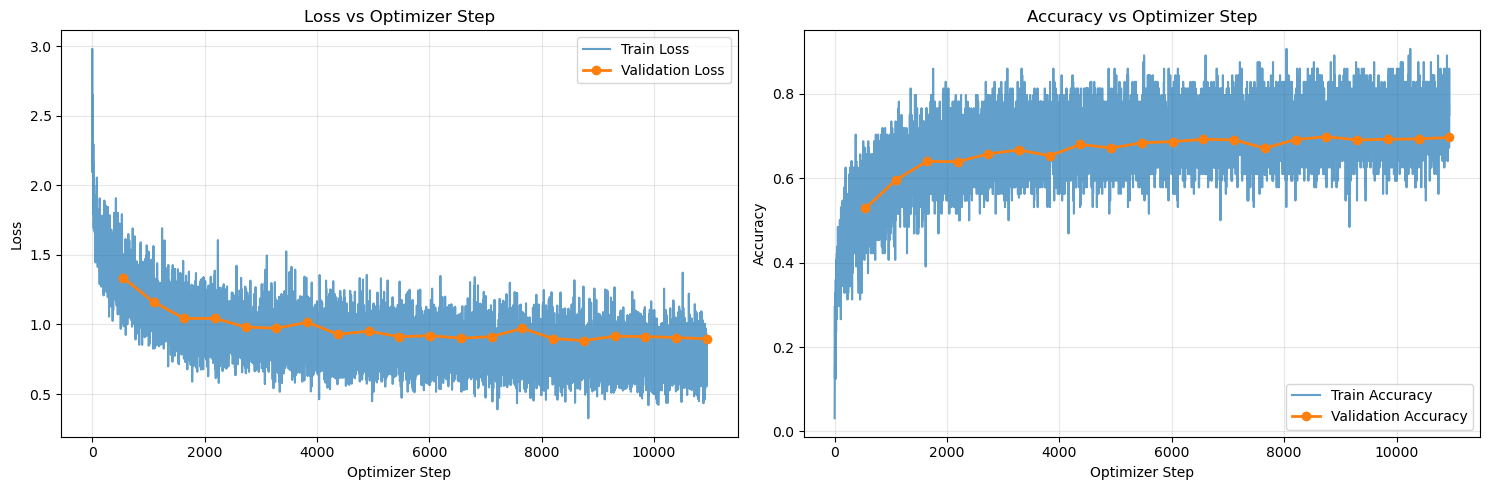

In [38]:
batches_per_epoch = len(train_loader)

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Loss vs Step
axes[0].plot(range(len(train_loss_log)), train_loss_log, label='Train Loss', alpha=0.7)
val_steps = [(i+1) * batches_per_epoch - 1 for i in range(len(val_loss_log))]
axes[0].plot(val_steps, val_loss_log, label='Validation Loss', marker='o', linewidth=2)
axes[0].set_xlabel('Optimizer Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss vs Optimizer Step')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Accuracy vs Step
axes[1].plot(range(len(train_acc_log)), train_acc_log, label='Train Accuracy', alpha=0.7)
axes[1].plot(val_steps, val_acc_log, label='Validation Accuracy', marker='o', linewidth=2)
axes[1].set_xlabel('Optimizer Step')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy vs Optimizer Step')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [39]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch  0 | Time:   5.24s | Train Loss: 1.5242 | Train Acc:  45.99% | Val Loss: 1.3153 | Val Acc:  53.73%
Epoch  1 | Time:   5.28s | Train Loss: 1.2068 | Train Acc:  57.69% | Val Loss: 1.1975 | Val Acc:  58.46%
Epoch  2 | Time:   5.27s | Train Loss: 1.0853 | Train Acc:  62.24% | Val Loss: 1.0972 | Val Acc:  61.67%
Epoch  3 | Time:   5.27s | Train Loss: 1.0190 | Train Acc:  64.74% | Val Loss: 1.0251 | Val Acc:  64.65%
Epoch  4 | Time:   5.26s | Train Loss: 0.9798 | Train Acc:  66.01% | Val Loss: 0.9765 | Val Acc:  65.62%
Epoch  5 | Time:   5.24s | Train Loss: 0.9465 | Train Acc:  67.22% | Val Loss: 0.9788 | Val Acc:  66.35%
Epoch  6 | Time:   5.21s | Train Loss: 0.9285 | Train Acc:  67.40% | Val Loss: 0.9827 | Val Acc:  66.25%
Epoch  7 | Time:   5.23s | Train Loss: 0.9111 | Train Acc:  68.29% | Val Loss: 0.9315 | Val Acc:  68.31%
Epoch  8 | Time:   5.22s | Train Loss: 0.8911 | Train Acc:  69.14% | Val Loss: 0.9241 | Val Acc:  68.08%
Epoch  9 | Time:   5.21s | Train Loss: 0.8809 | Train A

Посчитайте точность на тестовой выборке:

In [40]:
test_loss, test_acc = test(net, test_loader)
print(f'Test accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)')
print(f'Test loss: {test_loss:.4f}')

Test accuracy: 0.7127 (71.27%)
Test loss: 0.8437


**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [41]:
# Train with constant small learning rate (0.001)
net_constant_lr = BasicBlockNet().to(device)
optimizer_constant = optim.SGD(net_constant_lr.parameters(), lr=0.001, momentum=0.9)

tr_loss_const, tr_acc_const, val_loss_const, val_acc_const = train(
    net_constant_lr, optimizer_constant, 20, train_loader, val_loader
)

# Test accuracy
test_loss_const, test_acc_const = test(net_constant_lr, test_loader)
print(f'\n=== Results with constant lr=0.001 ===')
print(f'Test accuracy: {test_acc_const:.4f} ({test_acc_const*100:.2f}%)')
print(f'Test loss: {test_loss_const:.4f}')

Epoch  0 | Time:   5.24s | Train Loss: 1.7948 | Train Acc:  36.90% | Val Loss: 1.5868 | Val Acc:  44.28%
Epoch  1 | Time:   5.19s | Train Loss: 1.5182 | Train Acc:  46.48% | Val Loss: 1.4447 | Val Acc:  48.37%
Epoch  2 | Time:   5.19s | Train Loss: 1.4026 | Train Acc:  50.84% | Val Loss: 1.3723 | Val Acc:  51.69%
Epoch  3 | Time:   5.27s | Train Loss: 1.3268 | Train Acc:  53.36% | Val Loss: 1.2791 | Val Acc:  55.22%
Epoch  4 | Time:   5.26s | Train Loss: 1.2709 | Train Acc:  55.64% | Val Loss: 1.2325 | Val Acc:  57.09%
Epoch  5 | Time:   5.19s | Train Loss: 1.2210 | Train Acc:  57.38% | Val Loss: 1.1886 | Val Acc:  58.67%
Epoch  6 | Time:   5.27s | Train Loss: 1.1764 | Train Acc:  58.64% | Val Loss: 1.1404 | Val Acc:  60.30%
Epoch  7 | Time:   5.26s | Train Loss: 1.1392 | Train Acc:  60.14% | Val Loss: 1.1144 | Val Acc:  61.05%
Epoch  8 | Time:   5.22s | Train Loss: 1.1104 | Train Acc:  61.32% | Val Loss: 1.0742 | Val Acc:  62.93%
Epoch  9 | Time:   5.21s | Train Loss: 1.0837 | Train A

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

In [46]:
# 1. Косинусный шедулер - продуктовая sota
print('=' * 60 +'\n'+'1. CosineAnnealingLR' +'\n'+'=' * 60)

net_cosine = BasicBlockNet().to(device)
optimizer_cosine = optim.SGD(net_cosine.parameters(), lr=0.1, momentum=0.9)
scheduler_cosine = optim.lr_scheduler.CosineAnnealingLR(optimizer_cosine, T_max=20, eta_min=0.001)

tr_loss_cos, tr_acc_cos, val_loss_cos, val_acc_cos = train(
    net_cosine, optimizer_cosine, 20, train_loader, val_loader, scheduler_cosine
)

test_loss_cos, test_acc_cos = test(net_cosine, test_loader)
print(f'Test accuracy: {test_acc_cos:.4f} ({test_acc_cos*100:.2f}%)')
print(f'Test loss: {test_loss_cos:.4f}\n')


# 2. ExponentialLR - тоже норм кент
print('=' * 60 +'\n'+'2. ExponentialLR' +'\n'+'=' * 60)

net_exp = BasicBlockNet().to(device)
optimizer_exp = optim.SGD(net_exp.parameters(), lr=0.1, momentum=0.9)
scheduler_exp = optim.lr_scheduler.ExponentialLR(optimizer_exp, gamma=0.9)

tr_loss_exp, tr_acc_exp, val_loss_exp, val_acc_exp = train(
    net_exp, optimizer_exp, 20, train_loader, val_loader, scheduler_exp
)

test_loss_exp, test_acc_exp = test(net_exp, test_loader)
print(f'Test accuracy: {test_acc_exp:.4f} ({test_acc_exp*100:.2f}%)')
print(f'Test loss: {test_loss_exp:.4f}\n')


# 3. ReduceLROnPlateau - этот кент вообще адаптивный
print('=' * 60 +'\n'+'3. ReduceLROnPlateau' +'\n'+'=' * 60)

net_step = BasicBlockNet().to(device)
optimizer_step = optim.SGD(net_step.parameters(), lr=0.1, momentum=0.9)
scheduler_step = optim.lr_scheduler.StepLR(optimizer_step, step_size=7, gamma=0.1)

tr_loss_step, tr_acc_step, val_loss_step, val_acc_step = train(
    net_step, optimizer_step, 20, train_loader, val_loader, scheduler_step
)

test_loss_step, test_acc_step = test(net_step, test_loader)
print(f'Test accuracy: {test_acc_step:.4f} ({test_acc_step*100:.2f}%)')
print(f'Test loss: {test_loss_step:.4f}\n')


print('=' * 60 +'\n'+'Summary:' +'\n'+'=' * 60)
print(f"MultiStepLR (baseline):   Test Acc = {test_acc*100:.2f}%")
print(f"CosineAnnealingLR:        Test Acc = {test_acc_cos*100:.2f}%")
print(f"ExponentialLR:            Test Acc = {test_acc_exp*100:.2f}%")
print(f"StepLR:                   Test Acc = {test_acc_step*100:.2f}%")

1. CosineAnnealingLR
Epoch  0 | Time:   5.27s | Train Loss: 1.4877 | Train Acc:  47.16% | Val Loss: 1.2811 | Val Acc:  54.89%
Epoch  1 | Time:   5.25s | Train Loss: 1.1830 | Train Acc:  58.76% | Val Loss: 1.1912 | Val Acc:  59.09%
Epoch  2 | Time:   5.26s | Train Loss: 1.0708 | Train Acc:  62.80% | Val Loss: 1.0956 | Val Acc:  62.13%
Epoch  3 | Time:   5.29s | Train Loss: 1.0002 | Train Acc:  65.38% | Val Loss: 0.9934 | Val Acc:  65.61%
Epoch  4 | Time:   5.32s | Train Loss: 0.9631 | Train Acc:  66.43% | Val Loss: 0.9865 | Val Acc:  65.86%
Epoch  5 | Time:   5.26s | Train Loss: 0.9243 | Train Acc:  67.86% | Val Loss: 0.9307 | Val Acc:  67.88%
Epoch  6 | Time:   5.26s | Train Loss: 0.8929 | Train Acc:  69.17% | Val Loss: 0.9690 | Val Acc:  66.61%
Epoch  7 | Time:   5.27s | Train Loss: 0.8661 | Train Acc:  70.12% | Val Loss: 0.9237 | Val Acc:  68.35%
Epoch  8 | Time:   5.28s | Train Loss: 0.8365 | Train Acc:  71.01% | Val Loss: 0.9023 | Val Acc:  68.74%
Epoch  9 | Time:   5.31s | Train L

Your answers here:
1. CosineAnnealingLR - мой любимый косинусный шедулер, классика, мета, сота, whatever. Уменьшает lr с 0.1 до 0.001 за 20 эпох, причем в отличии от экспонециального, который тоже гладкий, даём много времени на обучение с больший значанием lr, потом достаточно, но не слишком быстро спускает с min и там бежит ещё примерно 1/3 всего времени. И это дало лучший результат: 72.25%, что выше baseline.

2. ExponentialLR - на каждой эпохе домнажает lr на gamma, получаем гладкое, быстрое (экспонециальное) затухание, поведение предсказуемое, неплох если боимся долго обучения на высоком lr, на в обычно используют косинус. Результат: уменьшение слишком быстрое, модель недоучивается -> хуже baseline: 70.51%.

3. StepLR – держит lr константным, а каждые 7 эпох (step_size эпох), умножает значение на gamma (0.1), т.е. делает несколько резкий ступеней. Поведение почти как MultiStepLR, и качество близко: 71.05%, чуть ниже baseline.

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

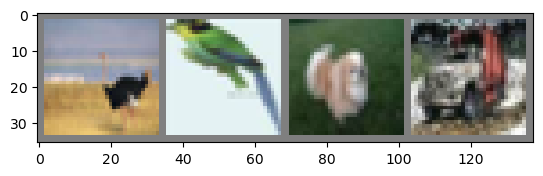

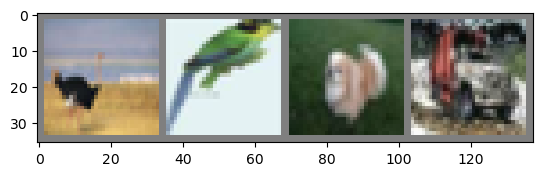

In [49]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [50]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch  0 | Time:   6.10s | Train Loss: 1.4940 | Train Acc:  46.90% | Val Loss: 1.2438 | Val Acc:  55.47%
Epoch  1 | Time:   6.14s | Train Loss: 1.1700 | Train Acc:  59.17% | Val Loss: 1.0699 | Val Acc:  62.78%
Epoch  2 | Time:   6.12s | Train Loss: 1.0659 | Train Acc:  62.78% | Val Loss: 1.0809 | Val Acc:  62.96%
Epoch  3 | Time:   6.08s | Train Loss: 1.0091 | Train Acc:  65.20% | Val Loss: 0.9928 | Val Acc:  65.45%
Epoch  4 | Time:   6.04s | Train Loss: 0.9712 | Train Acc:  66.52% | Val Loss: 1.0149 | Val Acc:  64.85%
Epoch  5 | Time:   6.07s | Train Loss: 0.9433 | Train Acc:  67.15% | Val Loss: 1.0099 | Val Acc:  64.96%
Epoch  6 | Time:   6.14s | Train Loss: 0.9179 | Train Acc:  68.23% | Val Loss: 0.9395 | Val Acc:  67.24%
Epoch  7 | Time:   6.15s | Train Loss: 0.9057 | Train Acc:  68.74% | Val Loss: 0.9245 | Val Acc:  68.69%
Epoch  8 | Time:   6.07s | Train Loss: 0.8915 | Train Acc:  69.17% | Val Loss: 0.916

Посчитайте точность на тестовой выборке:

In [51]:
test_loss, test_acc = test(net, test_loader)
print(f'Test accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)')
print(f'Test loss: {test_loss:.4f}')

Test accuracy: 0.7254 (72.54%)
Test loss: 0.7981


**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

In [52]:
# 1. RandomCrop with padding
print("=" * 60 + '\n' + '1. RandomCrop with padding' + '\n' + '=' * 60)

transform_crop = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_loader_crop, val_loader_crop, test_loader_crop = get_cifar10_data(batch_size=64, transform_train=transform_crop)

net_crop = BasicBlockNet().to(device)
optimizer_crop = optim.SGD(net_crop.parameters(), lr=0.1, momentum=0.9)
scheduler_crop = optim.lr_scheduler.MultiStepLR(optimizer_crop, milestones=[10, 15], gamma=0.1)
tr_loss_crop, tr_acc_crop, val_loss_crop, val_acc_crop = train(net_crop, optimizer_crop, 20, train_loader_crop, val_loader_crop, scheduler_crop)

test_loss_crop, test_acc_crop = test(net_crop, test_loader_crop)
print(f'Test accuracy: {test_acc_crop:.4f} ({test_acc_crop*100:.2f}%)')
print(f'Test loss: {test_loss_crop:.4f}\n')


# 2. ColorJitter
print("=" * 60 + '\n' + '2. ColorJitter' + '\n' + '=' * 60)

transform_color = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_loader_color, val_loader_color, test_loader_color = get_cifar10_data(batch_size=64, transform_train=transform_color)

net_color = BasicBlockNet().to(device)
optimizer_color = optim.SGD(net_color.parameters(), lr=0.1, momentum=0.9)
scheduler_color = optim.lr_scheduler.MultiStepLR(optimizer_color, milestones=[10, 15], gamma=0.1)
tr_loss_color, tr_acc_color, val_loss_color, val_acc_color = train(net_color, optimizer_color, 20, train_loader_color, val_loader_color, scheduler_color)

test_loss_color, test_acc_color = test(net_color, test_loader_color)
print(f'Test accuracy: {test_acc_color:.4f} ({test_acc_color*100:.2f}%)')
print(f'Test loss: {test_loss_color:.4f}\n')


# 3. RandomRotation
print("=" * 60 + '\n' + '3. RandomRotation' + '\n' + '=' * 60)

transform_rotation = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_loader_rotation, val_loader_rotation, test_loader_rotation = get_cifar10_data(batch_size=64, transform_train=transform_rotation)

net_rotation = BasicBlockNet().to(device)
optimizer_rotation = optim.SGD(net_rotation.parameters(), lr=0.1, momentum=0.9)
scheduler_rotation = optim.lr_scheduler.MultiStepLR(optimizer_rotation, milestones=[10, 15], gamma=0.1)
tr_loss_rotation, tr_acc_rotation, val_loss_rotation, val_acc_rotation = train(net_rotation, optimizer_rotation, 20, train_loader_rotation, val_loader_rotation, scheduler_rotation)

test_loss_rotation, test_acc_rotation = test(net_rotation, test_loader_rotation)
print(f'Test accuracy: {test_acc_rotation:.4f} ({test_acc_rotation*100:.2f}%)')
print(f'Test loss: {test_loss_rotation:.4f}\n')


# 4. Combination: HorizontalFlip + RandomCrop + ColorJitter
print("=" * 60)
print("4. Combined augmentations: HorizontalFlip + RandomCrop + ColorJitter")
print("=" * 60)

transform_combined = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_loader_combined, val_loader_combined, test_loader_combined = get_cifar10_data(batch_size=64, transform_train=transform_combined)

net_combined = BasicBlockNet().to(device)
optimizer_combined = optim.SGD(net_combined.parameters(), lr=0.1, momentum=0.9)
scheduler_combined = optim.lr_scheduler.MultiStepLR(optimizer_combined, milestones=[10, 15], gamma=0.1)
tr_loss_combined, tr_acc_combined, val_loss_combined, val_acc_combined = train(net_combined, optimizer_combined, 20, train_loader_combined, val_loader_combined, scheduler_combined)

test_loss_combined, test_acc_combined = test(net_combined, test_loader_combined)
print(f'Test accuracy: {test_acc_combined:.4f} ({test_acc_combined*100:.2f}%)')
print(f'Test loss: {test_loss_combined:.4f}\n')


# Summary
print("=" * 60)
print("Summary:")
print("=" * 60)
print(f"Baseline (no augmentation):        Test Acc = {test_acc_const*100:.2f}%")
print(f"HorizontalFlip:                    Test Acc = {test_acc*100:.2f}%")
print(f"RandomCrop:                        Test Acc = {test_acc_crop*100:.2f}%")
print(f"ColorJitter:                       Test Acc = {test_acc_color*100:.2f}%")
print(f"RandomRotation:                    Test Acc = {test_acc_rotation*100:.2f}%")
print(f"Combined augmentations:            Test Acc = {test_acc_combined*100:.2f}%")

1. RandomCrop with padding
Files already downloaded and verified
Files already downloaded and verified
Epoch  0 | Time:   7.04s | Train Loss: 1.6824 | Train Acc:  39.12% | Val Loss: 1.5180 | Val Acc:  43.68%
Epoch  1 | Time:   7.14s | Train Loss: 1.3896 | Train Acc:  50.23% | Val Loss: 1.2907 | Val Acc:  53.73%
Epoch  2 | Time:   7.10s | Train Loss: 1.2628 | Train Acc:  55.61% | Val Loss: 1.1827 | Val Acc:  58.52%
Epoch  3 | Time:   7.20s | Train Loss: 1.2007 | Train Acc:  57.63% | Val Loss: 1.2642 | Val Acc:  56.56%
Epoch  4 | Time:   7.16s | Train Loss: 1.1609 | Train Acc:  59.14% | Val Loss: 1.2103 | Val Acc:  58.19%
Epoch  5 | Time:   7.05s | Train Loss: 1.1372 | Train Acc:  60.31% | Val Loss: 1.1012 | Val Acc:  61.32%
Epoch  6 | Time:   7.17s | Train Loss: 1.1034 | Train Acc:  61.33% | Val Loss: 1.0726 | Val Acc:  62.51%
Epoch  7 | Time:   7.22s | Train Loss: 1.0890 | Train Acc:  61.63% | Val Loss: 1.1339 | Val Acc:  60.73%
Epoch  8 | Time:   7.11s | Train Loss: 1.0727 | Train Acc

Your answers here:

1. Horizontal Flip (given)  - в целом уже описано: с 50% шансом отражает картинку относительно центра -> стало лучше
2. RandomCrop: сначала паддингом добавляем черную рамку, в 4 пиксела, от туда выбираем случайным образом картинку  32x32. Это иметирует небольшой сдвиг картинки -> лучше чем baseline, но хуже чем HF
3. ColorJitter - Случайно меняет яркость, контраст, насыщенность и оттенок (hue) -> сопоставимый прирост с HF
4. RandomRotation - поворачивает картинку на случайный угол в пределах +- 15% -> лушче baseline, но хуже чем HF
5. Combined augmentations (Flip + Crop + ColorJitter) - очевидно что делает, а вот результат неожиданный. Возможно переборщил для такой простой сетки, либо мало эпох + большой lr 

## Бонус. Логирование в comet (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. ~~Вероятно, самый популярный из них — [wandb](https://wandb.ai/site)~~ Например: [TensorBoard](https://docs.pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html), [comet](https://www.comet.com), [wandb](https://wandb.ai/). Выберите любой удобный из них.

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код, публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2 или выхлоп тензорбоард.

In [57]:
# Configuration for training with comet_ml logging
BATCH_SIZE = 1024
N_EPOCHS = 300
LEARNING_RATE = 0.1
MOMENTUM = 0.9

with open('api_key.txt', 'r') as file:
    api_key = file.read().strip()

experiment = comet_ml.Experiment(
    api_key=api_key,
    project_name="dlhw2",
    workspace="ivan-novosad",
)

# Log hyperparameters (fixed to match actual configuration)
experiment.log_parameters({
    "learning_rate": LEARNING_RATE,
    "epochs": N_EPOCHS,
    "batch_size": BATCH_SIZE,
    "optimizer": "SGD",
    "momentum": MOMENTUM,
    "scheduler": "ReduceLROnPlateau",
    "scheduler_mode": "min",
    "scheduler_factor": 0.1,
    "scheduler_patience": 10,
    "scheduler_min_lr": 1e-6,
    "model": "BasicBlockNet"
})

def test_with_logging(model, loader, experiment=None):
    loss_log = []
    acc_log = []
    model.eval()
    
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        
        with torch.no_grad():
            output = model(data)
            loss = F.cross_entropy(output, target)
        
        loss_log.append(loss.item())
        
        pred = output.argmax(dim=1)
        acc = (pred == target).float().mean()
        
        acc_log.append(acc.item()) 
        
    return np.mean(loss_log), np.mean(acc_log)

def train_epoch_with_logging(model, optimizer, train_loader, experiment, step_offset):
    loss_log = []
    acc_log = []
    model.train()
    step = step_offset
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1)
        acc = (pred == target).float().mean()
        
        # Log to Comet ML for each batch
        experiment.log_metric("train_loss", loss.item(), step=step)
        experiment.log_metric("train_accuracy", acc.item(), step=step)
        
        loss_log.append(loss.item())
        acc_log.append(acc.item())
        step += 1

    return loss_log, acc_log, step

def train_with_logging(model, optimizer, n_epochs, train_loader, val_loader, experiment, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []
    step = 0

    for epoch in range(n_epochs):
        epoch_start_time = time.time()
        
        train_loss, train_acc, step = train_epoch_with_logging(model, optimizer, train_loader, experiment, step)
        val_loss, val_acc = test_with_logging(model, val_loader, experiment)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)
        
        # Log validation metrics
        experiment.log_metric("val_loss", val_loss, epoch=epoch)
        experiment.log_metric("val_accuracy", val_acc, epoch=epoch)
        
        epoch_time = time.time() - epoch_start_time
        
        # Print with nice formatting
        print(f"Epoch {epoch:3d} | Time: {epoch_time:6.2f}s | "
              f"Train Loss: {np.mean(train_loss):.4f} | Train Acc: {np.mean(train_acc)*100:6.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:6.2f}%")
        
        if scheduler is not None:
            scheduler.step(val_loss)  # Pass val_loss for ReduceLROnPlateau
            experiment.log_metric("learning_rate", optimizer.param_groups[0]['lr'], epoch=epoch)

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

# Data preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=BATCH_SIZE, transform_train=transform)

# Model initialization
net_logged = BasicBlockNet().to(device)
optimizer_logged = optim.SGD(net_logged.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
# ReduceLROnPlateau: adaptive learning rate reduction based on validation loss
scheduler_logged = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_logged, 
    mode='min',           # minimize validation loss
    factor=0.1,          # multiply LR by 0.1 when reducing
    patience=10,         # wait 10 epochs before reducing
    min_lr=1e-6         # minimum learning rate
)

print(f"Starting training for {N_EPOCHS} epochs with batch size {BATCH_SIZE}")
print(f"Dataset sizes: Train={len(train_loader.dataset)}, Val={len(val_loader.dataset)}, Test={len(test_loader.dataset)}")
print(f"Batches per epoch: {len(train_loader)}")
print(f"Using ReduceLROnPlateau: LR will be reduced by 10x when val loss doesn't improve for 10 epochs")
print("=" * 100)

train_loss_log, train_acc_log, val_loss_log, val_acc_log = train_with_logging(
    net_logged, optimizer_logged, N_EPOCHS, train_loader, val_loader, experiment, scheduler_logged
)

print("=" * 100)
# Test accuracy
test_loss_logged, test_acc_logged = test_with_logging(net_logged, test_loader, experiment)
print(f'\nFinal Test Results:')
print(f'  Test Accuracy: {test_acc_logged:.4f} ({test_acc_logged*100:.2f}%)')
print(f'  Test Loss:     {test_loss_logged:.4f}')

# Log test metrics
experiment.log_metric("test_loss", test_loss_logged)
experiment.log_metric("test_accuracy", test_acc_logged)

# Create and log the plots
batches_per_epoch = len(train_loader)

# Plot 1: Loss vs Step
fig1, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(range(len(train_loss_log)), train_loss_log, label='Train Loss', alpha=0.6, linewidth=0.8)
val_steps = [(i+1) * batches_per_epoch - 1 for i in range(len(val_loss_log))]
ax1.plot(val_steps, val_loss_log, label='Validation Loss', marker='o', markersize=3, linewidth=2)
ax1.set_xlabel('Optimizer Step')
ax1.set_ylabel('Loss')
ax1.set_title(f'Loss vs Optimizer Step (Batch Size={BATCH_SIZE}, {N_EPOCHS} Epochs)')
ax1.legend()
ax1.grid(True, alpha=0.3)
experiment.log_figure("loss_plot", fig1)

# Plot 2: Accuracy vs Step
fig2, ax2 = plt.subplots(figsize=(12, 6))
ax2.plot(range(len(train_acc_log)), train_acc_log, label='Train Accuracy', alpha=0.6, linewidth=0.8)
ax2.plot(val_steps, val_acc_log, label='Validation Accuracy', marker='o', markersize=3, linewidth=2)
ax2.set_xlabel('Optimizer Step')
ax2.set_ylabel('Accuracy')
ax2.set_title(f'Accuracy vs Optimizer Step (Batch Size={BATCH_SIZE}, {N_EPOCHS} Epochs)')
ax2.legend()
ax2.grid(True, alpha=0.3)
experiment.log_figure("accuracy_plot", fig2)

# Plot 3: Loss vs Epoch (validation only)
fig3, ax3 = plt.subplots(figsize=(10, 6))
ax3.plot(range(len(val_loss_log)), val_loss_log, marker='o', markersize=3, linewidth=2, color='tab:orange', label='Validation Loss')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Validation Loss')
ax3.set_title(f'Validation Loss vs Epoch (Batch Size={BATCH_SIZE}, ReduceLROnPlateau)')
ax3.legend()
ax3.grid(True, alpha=0.3)
experiment.log_figure("val_loss_vs_epoch", fig3)

# Plot 4: Accuracy vs Epoch (validation only)
fig4, ax4 = plt.subplots(figsize=(10, 6))
ax4.plot(range(len(val_acc_log)), [acc*100 for acc in val_acc_log], marker='o', markersize=3, linewidth=2, color='tab:green', label='Validation Accuracy')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Validation Accuracy (%)')
ax4.set_title(f'Validation Accuracy vs Epoch (Batch Size={BATCH_SIZE}, ReduceLROnPlateau)')
ax4.legend()
ax4.grid(True, alpha=0.3)
experiment.log_figure("val_acc_vs_epoch", fig4)

plt.close('all')

print(f"\nView your results at: {experiment.url}")

# End the experiment
experiment.end()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


COMET WARNING: Failed to log ip
COMET INFO: Experiment is live on comet.com https://www.comet.com/ivan-novosad/dlhw2/6ccc241f5af6400d95077b0a008e7a4f

COMET INFO: Couldn't find a Git repository in '/home/ianovosad/junk/dlhw2' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


Files already downloaded and verified
Files already downloaded and verified
Starting training for 300 epochs with batch size 1024
Dataset sizes: Train=35000, Val=15000, Test=10000
Batches per epoch: 35
Using ReduceLROnPlateau: LR will be reduced by 10x when val loss doesn't improve for 10 epochs
Epoch   0 | Time:   4.94s | Train Loss: 1.7005 | Train Acc:  39.23% | Val Loss: 1.5129 | Val Acc:  45.46%
Epoch   1 | Time:   4.95s | Train Loss: 1.3677 | Train Acc:  51.20% | Val Loss: 1.3506 | Val Acc:  52.24%
Epoch   2 | Time:   4.92s | Train Loss: 1.2634 | Train Acc:  55.35% | Val Loss: 1.2721 | Val Acc:  54.95%
Epoch   3 | Time:   4.93s | Train Loss: 1.1915 | Train Acc:  57.84% | Val Loss: 1.2361 | Val Acc:  56.44%
Epoch   4 | Time:   5.00s | Train Loss: 1.1226 | Train Acc:  60.45% | Val Loss: 1.4391 | Val Acc:  51.34%
Epoch   5 | Time:   4.93s | Train Loss: 1.0533 | Train Acc:  63.19% | Val Loss: 1.1060 | Val Acc:  61.16%
Epoch   6 | Time:   4.98s | Train Loss: 1.0257 | Train Acc:  64.24%

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : estimated_snake_5680
COMET INFO:     url                   : https://www.comet.com/ivan-novosad/dlhw2/6ccc241f5af6400d95077b0a008e7a4f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     learning_rate [300]    : (1.0000000000000004e-06, 0.1)
COMET INFO:     test_accuracy          : 0.7518116235733032
COMET INFO:     test_loss              : 0.7420198619365692
COMET INFO:     train_accuracy [10500] : (0.0927734375, 0.8804348111152649)
COMET INFO:     train_loss [10500]     : (0.35241007804870605, 2.430819034576416)
COMET INFO:     val_accuracy [300]     : (0.4546380817890167, 0.7600699663162231)
COMET INFO:     val_loss [300]         : (0.720265


View your results at: https://www.comet.com/ivan-novosad/dlhw2/6ccc241f5af6400d95077b0a008e7a4f


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET WARNING: Failed to log ip
COMET INFO: Experiment is live on comet.com https://www.comet.com/ivan-novosad/dlhw2-section2/6e543651a0c64c639d78419e8ba52c7c

COMET INFO: Couldn't find a Git repository in '/home/ianovosad/junk/dlhw2' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


Files already downloaded and verified
Files already downloaded and verified
Training BasicBlockNet with Comet logging (20 epochs)
Epoch  0 | Time:   5.79s | Train Loss: 1.4860 | Train Acc:  47.48% | Val Loss: 1.2828 | Val Acc:  54.43%
Epoch  1 | Time:   5.89s | Train Loss: 1.1699 | Train Acc:  59.04% | Val Loss: 1.1072 | Val Acc:  61.39%
Epoch  2 | Time:   5.98s | Train Loss: 1.0545 | Train Acc:  63.53% | Val Loss: 1.0361 | Val Acc:  64.36%
Epoch  3 | Time:   5.85s | Train Loss: 0.9921 | Train Acc:  65.60% | Val Loss: 1.0334 | Val Acc:  64.85%
Epoch  4 | Time:   5.76s | Train Loss: 0.9514 | Train Acc:  66.90% | Val Loss: 1.0050 | Val Acc:  65.19%
Epoch  5 | Time:   5.68s | Train Loss: 0.9205 | Train Acc:  68.07% | Val Loss: 0.9727 | Val Acc:  66.12%
Epoch  6 | Time:   5.71s | Train Loss: 0.9011 | Train Acc:  68.84% | Val Loss: 0.9534 | Val Acc:  66.78%
Epoch  7 | Time:   5.68s | Train Loss: 0.8857 | Train Acc:  69.38% | Val Loss: 0.9376 | Val Acc:  67.70%
Epoch  8 | Time:   5.72s | Tra

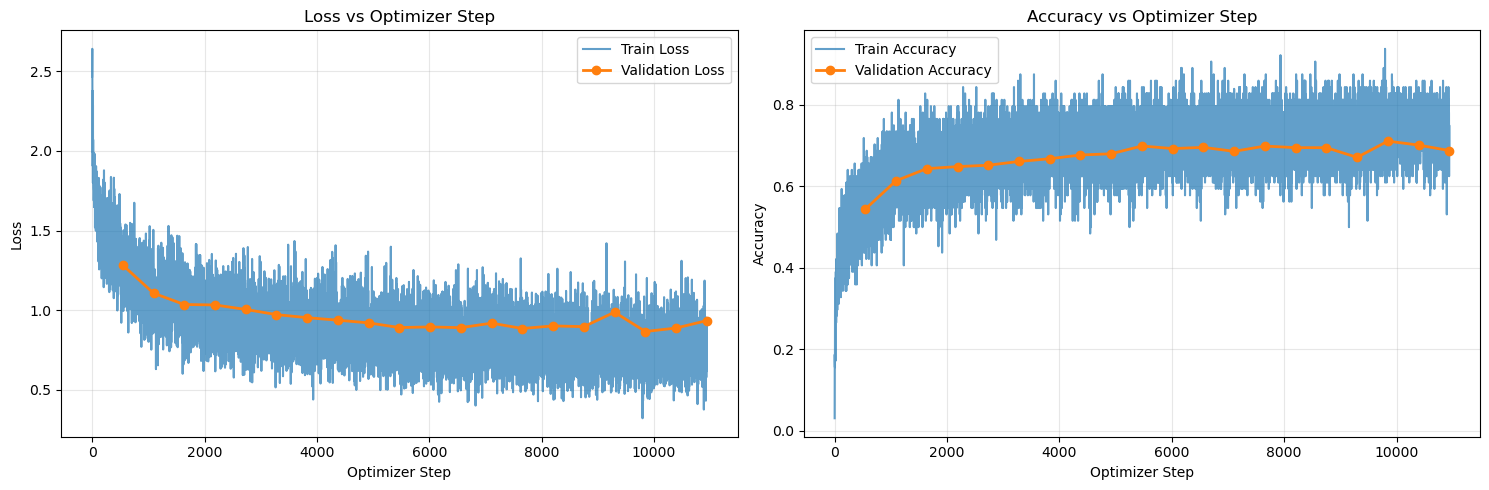

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : average_eaves_6621
COMET INFO:     url                   : https://www.comet.com/ivan-novosad/dlhw2-section2/6e543651a0c64c639d78419e8ba52c7c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     test_acc           : 0.6779458598726115
COMET INFO:     test_loss          : 0.958754652624677
COMET INFO:     train_acc [10940]  : (0.03125, 0.9375)
COMET INFO:     train_loss [10940] : (0.32233843207359314, 2.640695810317993)
COMET INFO:     val_acc [20]       : (0.5443040781832756, 0.7110815603682336)
COMET INFO:     val_loss [20]      : (0.8667075632734501, 1.2828243981016443)
COMET INFO:   Parameters:
COMET INFO:     batch_size    : 64
COMET INFO:  


View your results at: https://www.comet.com/ivan-novosad/dlhw2-section2/6e543651a0c64c639d78419e8ba52c7c


In [58]:
## 2.1 and 2.2 with Comet Logging

# Read API key
with open('api_key.txt', 'r') as file:
    api_key = file.read().strip()

# Create Comet experiment
experiment = comet_ml.Experiment(
    api_key=api_key,
    project_name="dlhw2-section2",
    workspace="ivan-novosad",
)

# Log hyperparameters
experiment.log_parameters({
    "learning_rate": 0.1,
    "epochs": 20,
    "batch_size": 64,
    "optimizer": "SGD",
    "momentum": 0.9,
    "scheduler": None,
    "model": "BasicBlockNet"
})

def test_comet(model, loader, experiment, epoch):
    loss_log = []
    acc_log = []
    model.eval()
    
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        
        with torch.no_grad():
            output = model(data)
            loss = F.cross_entropy(output, target)
        
        loss_log.append(loss.item())
        
        pred = output.argmax(dim=1)
        acc = (pred == target).float().mean()
        
        acc_log.append(acc.item()) 
    
    avg_loss = np.mean(loss_log)
    avg_acc = np.mean(acc_log)
    
    # Log to comet
    experiment.log_metric("val_loss", avg_loss, epoch=epoch)
    experiment.log_metric("val_acc", avg_acc, epoch=epoch)
        
    return avg_loss, avg_acc

def train_epoch_comet(model, optimizer, train_loader, experiment, epoch, step_offset):
    loss_log = []
    acc_log = []
    model.train()
    step = step_offset
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.item())
        
        pred = output.argmax(dim=1)
        acc = (pred == target).float().mean()
        
        acc_log.append(acc.item())
        
        # Log to comet for each batch
        experiment.log_metric("train_loss", loss.item(), step=step)
        experiment.log_metric("train_acc", acc.item(), step=step)
        step += 1

    return loss_log, acc_log, step

def train_comet(model, optimizer, n_epochs, train_loader, val_loader, experiment, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []
    step = 0

    for epoch in range(n_epochs):
        epoch_start_time = time.time()
        
        train_loss, train_acc, step = train_epoch_comet(model, optimizer, train_loader, experiment, epoch, step)
        val_loss, val_acc = test_comet(model, val_loader, experiment, epoch)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        epoch_time = time.time() - epoch_start_time
        
        print(f"Epoch {epoch:2d} | Time: {epoch_time:6.2f}s | "
              f"Train Loss: {np.mean(train_loss):.4f} | Train Acc: {np.mean(train_acc)*100:6.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:6.2f}%")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

# Data preparation - same as section 2
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

# Model initialization - same as section 2
net_comet = BasicBlockNet().to(device)
optimizer_comet = optim.SGD(net_comet.parameters(), lr=0.1, momentum=0.9)

# Train for 20 epochs (same as original sections 2.1 and 2.2)
print("Training BasicBlockNet with Comet logging (20 epochs)")
print("=" * 80)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train_comet(
    net_comet, optimizer_comet, 20, train_loader, val_loader, experiment
)
print("=" * 80)

# Test accuracy
test_loss, test_acc = test(net_comet, test_loader)
print(f'\nTest accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)')
print(f'Test loss: {test_loss:.4f}')

# Log test metrics to comet
experiment.log_metric("test_loss", test_loss)
experiment.log_metric("test_acc", test_acc)

# Create plots - same as section 2.2
batches_per_epoch = len(train_loader)

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Loss vs Step
axes[0].plot(range(len(train_loss_log)), train_loss_log, label='Train Loss', alpha=0.7)
val_steps = [(i+1) * batches_per_epoch - 1 for i in range(len(val_loss_log))]
axes[0].plot(val_steps, val_loss_log, label='Validation Loss', marker='o', linewidth=2)
axes[0].set_xlabel('Optimizer Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss vs Optimizer Step')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Accuracy vs Step
axes[1].plot(range(len(train_acc_log)), train_acc_log, label='Train Accuracy', alpha=0.7)
axes[1].plot(val_steps, val_acc_log, label='Validation Accuracy', marker='o', linewidth=2)
axes[1].set_xlabel('Optimizer Step')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy vs Optimizer Step')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Log the figure to comet
experiment.log_figure("training_plots", fig)

print(f"\nView your results at: {experiment.url}")

# End the experiment
experiment.end()
